In [523]:
# This code fits a Fourier spectrum to the SGS topography corresponding
# to a given lat,lon. The workflow is as follows: find the low-res ICON triangle
# whose centroid is closest to the given reference location, fetch the data within 
# this triangle, fit the linear-regression-based Fourier spectrum to it, and finally 
# plot the spectrum and the reconstructed topography along with the reference truth.
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy.ma as ma
from topoPy import *

vmin=-1500; vmax=1500

In [524]:
# ICON grid file
df = nc.Dataset('../data/icon_grid_0012_R02B04_G_linked.nc')
# df = nc.Dataset('../data/icon_grid_0012_R02B04_G.nc')
# print(df.variables)

# store the lat,lon of the vertices and the centre of each triangular grid
clat = ma.getdata(df.variables['clat'][:])
clat_vertices = ma.getdata(df.variables['clat_vertices'][:])
clon = ma.getdata(df.variables['clon'][:])
clon_vertices = ma.getdata(df.variables['clon_vertices'][:])

vid = 0
print(clon_vertices[vid])
print(clon_vertices.min(), clon_vertices.max())
print(np.abs(clon_vertices).min())

# change to degrees
clat, clat_vertices = clat*(180/np.pi), clat_vertices*(180/np.pi)
clon, clon_vertices = clon*(180/np.pi), clon_vertices*(180/np.pi)

print(clon_vertices[vid])


# clat[np.where(clat < 0.0)] += 360.0
# clon[np.where(clon < 0.0)] += 360.0
    
# clat_vertices[np.where(clat_vertices < 0.0)] += 360.0
# clon_vertices[np.where(clon_vertices < 0.0)] += 360.0

# vid = 0
print(clon_vertices[vid])


print(clon_vertices.min(), clon_vertices.max())
print(np.abs(clon_vertices).min())
# print(clat_vertices[vid])

[-2.89070893  0.62831853  1.88495559]
-3.141592653589793 3.141592653589793
0.0
[-165.6254214   36.         108.       ]
[-165.6254214   36.         108.       ]
-180.0 180.0
0.0


In [525]:
# pick the cell around the reference lat,lon
def pickCell(lat_ref, lon_ref, clat, clon):
    index = np.nonzero((np.abs(clat-lat_ref)<=1) & 
                       (np.abs(clon-lon_ref)<=1))[0]
    
    print("index = ", index)
    # pick the centre closest to the reference location
    dist = np.abs(clat[index]-lat_ref) + np.abs(clon[index]-lon_ref) 
    print("dist = ", dist)
    ind = np.argmin(dist)
    print("ind = ", ind)
    return index[ind]

In [526]:
# N_coor = -31.8894588
# E_coor = -70.6014078
N_coor = 45
E_coor = 45

print(np.argmin(clat - N_coor))
print(np.argmin(clon - E_coor))

17408
11272


In [527]:
def fetch_data_vw(datfile,var,lon_centre,lat_centre,lon_vert,lat_vert):
    
    #---- variable and the coordinates
    lon, lat, z = readnc(datfile, var)
    
    lon_orig = np.copy(lon)
    # lon_360 = np.copy(lon)
    # lon[np.where(lon_360 < 0.0)] += 360
    
    print(lat.min(),lat.max())
    print(lon.min(),lon.max())
    
    #---- get number of records,nlat,nlon
    nrecords = np.shape(z)[0]; nlon = np.shape(lon)[1]; nlat = np.shape(lat)[1]
    
    #---- process each record to get the (lon,lat) for each topographic observation in 1D
    lon_res=[]; lat_res=[]; z_res=[]   # resulting lon,lat,z  
    
    for n in range(nrecords):
        print('n = ',n)
        lon_,lat_ = np.meshgrid(lon[n][:],lat[n][:])
#         print(lon_, lat_)
        lon_= lon_.ravel() 
        lat_ = lat_.ravel() 
        z_ = np.flipud(z[n][:]).ravel() 
#         print(lon_.shape, lat_.shape, z_.shape)
        cond_lat = ( lat_vert.min() <= lat_ ) & ( lat_ <= lat_vert.max() )
        cond_lon = ( lon_vert.min() <= lon_ ) & ( lon_ <= lon_vert.max() )
        idx = np.nonzero((cond_lat & cond_lon))[0]

        # idx = np.nonzero((np.abs(lon_ - lon_centre)<= lon_width/2) & 
                         # (np.abs(lat_ - lat_centre)<= lat_width/2))[0]
        print(idx)
        if len(idx)!=0:
            lon_dummy,lat_dummy,z_dummy = lon_[idx],lat_[idx],z_[idx]
            lon_res.extend(lon_dummy.tolist())
            lat_res.extend(lat_dummy.tolist())
            z_res.extend(z_dummy.tolist())
    
    lon_res = np.array(lon_res)
    lat_res = np.array(lat_res)
    z_res = np.array(z_res)
        
    del lat, lon, z
        
    #---- processing of the lat,lon,topo to get the regular 2D grid for topography
    lon_uniq, lat_uniq = np.unique(lon_res), np.unique(lat_res) # get unique values of lon,lat
    nla = len(lat_uniq); nlo = len(lon_uniq)
    
    print("lat_res shape = ", lat_res.shape)
    print("lon_res shape = ", lon_res.shape)
    print("z_res shape = ", z_res.shape)
    print("nla = ", nla)
    print("nlo = ", nlo)

    #---- building 2D topography field
    lat_lon_topo = np.vstack((lat_res,lon_res,z_res)).T
    lat_lon_topo = lat_lon_topo[lat_lon_topo[:,0].argsort()]  # sorted according to latitude
    lon_sort_id = [lat_lon_topo[n*nlo:(n+1)*nlo,1].argsort()+nlo*n for n in range(nla)] 
    lon_sort_id = np.array(lon_sort_id).reshape(-1)
    lat_lon_topo = lat_lon_topo[lon_sort_id]  # sorted according to longitude for each len(lon_u)
    topo_2D = np.reshape(lat_lon_topo[:,2],(nla,nlo))
    del lat_lon_topo, lon_sort_id
        
    print('Data fetched...')
    return lon_uniq, lat_uniq, topo_2D

In [528]:
#---- pick the ICON cell for a given reference location
lat_ref = 43
lon_ref = 42

# lat_ref = -32
# lon_ref = -71
# lat_ref, lon_ref = 28, 87 # Langtang National Park, Nepal
# lat_ref, lon_ref = 42,23 # Pirin National Park, Bulgaria
# lat_ref, lon_ref = 50,8 # Taunus
# lat_ref, lon_ref = 46,8 # Firehorn, Switzerland
vid = pickCell(lat_ref,lon_ref,clat,clon) # pick a vertex
print('Vertex ID:',vid)
vid = 3584
vid = 3186
vid = 440
# vid = 5026
# vid = 1677
# vid = 1440
# vid = 1110
# vid = 3028
# vid = 1117
# vid = 3247
# vid = 5246
# vid = 0

#---- get the data for the picked cell
datfile = '../data/GMTED2010_topoGlobal_SGS_30ArcSec.nc'
var = {'name':'topo','units':'m'}
#---- set (lon,lat) of the centre of the grid
lon_centre = clon[vid]    # in degrees
lat_centre = clat[vid]    # in degrees
#---- set the periphery of the coarse grid around the centre 
lon_width = 240  # in degrees
lat_width = 8  # in degrees
# #---- get the topography around the cell picked
# %time lon,lat,z = fetch_data(datfile,var,lon_centre,lat_centre,lon_width,lat_width)
%time lon,lat,z = fetch_data_vw(datfile,var,lon_centre,lat_centre,clon_vertices[vid,:],clat_vertices[vid,:])

index =  [440]
dist =  [0.71705466]
ind =  0
Vertex ID: 440
{'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(nfiles, lat)
    units: degrees
unlimited dimensions: 
current shape = (108, 2400)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(nfiles, lon)
    units: degrees
unlimited dimensions: 
current shape = (108, 3600)
filling on, default _FillValue of 9.969209968386869e+36 used, 'topo': <class 'netCDF4._netCDF4.Variable'>
float32 topo(nfiles, lat, lon)
    units: meters
unlimited dimensions: 
current shape = (108, 2400, 3600)
filling on, default _FillValue of 9.969209968386869e+36 used}
-89.995834 89.995834
-179.99583 179.99583
n =  0
[]
n =  1
[]
n =  2
[]
n =  3
[]
n =  4
[]
n =  5
[]
n =  6
[]
n =  7
[]
n =  8
[]
n =  9
[]
n =  10
[]
n =  11
[]
n =  12
[]
n =  13
[]
n =  14
[]
n =  15
[]
n =  16
[]
n =  17
[]
n =  18
[]
n =  19
[]
n =  20
[]
n =  21
[]
n =  22
[]
n =  23
[]
n =  24
[]
n =  25
[]
n =  26
[

In [9]:
print(clon_vertices.shape)
print(clon_vertices[vid,:])
clv = clon_vertices[vid,:]

print(clon[vid])
print(clv[2]-clv[0])
print(clv.min() - clon[vid])

(20480, 3)
[41.44424379 41.24515306 43.96808206]
42.3106940197024
2.523838271410149
-1.0655409637253186


In [7]:
# lat = np.linspace(0, 2.0 * np.pi, 480)
# lon = np.linspace(0, 2.0 * np.pi, 480)

# vid = 0
# clon_vertices = np.array([[0, np.pi, 2.0 * np.pi],])
# clat_vertices = np.array([[0, 2.0 * np.pi, 0],])

# # clat_vertices = np.array([[0, np.pi, 2.0 * np.pi],])
# # clon_vertices = np.array([[0, 2.0 * np.pi, 0],])

# # clon_vertices = np.array([[0, 0, 2.0 * np.pi],])
# # clat_vertices = np.array([[0, 2.0 * np.pi, 2.0 ],])

# lat_m, lon_m = np.meshgrid(lat,lon)
# # z = np.sin(5.0*lon_m + 5.0*lat_m)
# z = np.sin(1.0 * lon_m)
# # z *= 0.0
# # z += 5.0

#### Plot the topo and the ICON triangle

In [529]:
plt.contourf(lon,lat,z,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.colorbar()
plt.show()

#### Plot the topo within the ICON triangle

In [530]:
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]
inout = [pointInTriangle(vi,vj,i,j) for i in lat for j in lon]
inout = np.array(inout).reshape(len(lat),len(lon))
# inout[...] = True
z_masked = z*inout

In [531]:
plt.contourf(lon,lat,z_masked,60)
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
plt.plot(x,y,'-r')
plt.colorbar()
plt.show()

#### Test the error when we do not do a projection from the isocahedral triangular grid to a 2D Cartesian plane

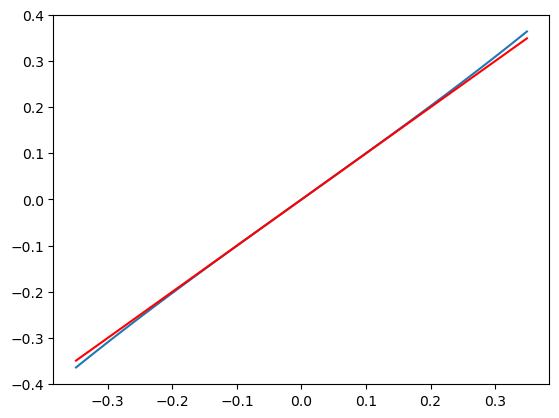

0.05743530860334995


In [14]:
tmin = -20.0 / 180 * np.pi
tmax = -tmin
trange = np.linspace(tmin, tmax, 100)
plt.figure()
plt.plot(trange , np.tan(trange))
plt.plot(trange, trange ,'r')
# plt.xlabel(trange, trange / np.pi * 180)
plt.show()

print(np.linalg.norm(np.tan(trange) - trange))

#### Lat-lon to X-Y Cartesian projection 

In [532]:
A = 6371.0008
A = 1.0

print(lat.min(), lat.max())
print(lon.min(), lon.max())

def ll_xy_projection(lat, lon, lat_c, lon_c):
    lat = lat / 180.0 * np.pi
    lon = lon / 180.0 * np.pi
    lat_c = lat_c / 180.0 * np.pi
    lon_c = lon_c / 180.0 * np.pi
    dlat = lat - lat_c
    dlon = lon - lon_c
    print("max(dlat, dlon) = ", dlat.max(), dlon.max())
    
    xp = A * np.cos(lat) * dlon
    yp = A * dlat
    
    return yp, xp

# ll_xy_projection(lat, lon, lat_centre, lon_centre)
lat_proj, lon_proj = ll_xy_projection(lat, lon, lat_centre, lon_centre)

print(lat_proj.min(), lat_proj.max())
print(lon_proj.min(), lon_proj.max())

41.63750076293945 43.662498474121094
41.24583435058594 43.962501525878906
max(dlat, dlon) =  0.018655110762223925 0.028829479591936602


ValueError: operands could not be broadcast together with shapes (244,) (327,) 

#### We test how the projection looks like.

max(dlat, dlon) =  -0.6337369761349742 -0.6287986483244663
[-0.74339925 -0.63373698 -0.74339925] [-0.73846092 -0.6795233  -0.62879865]


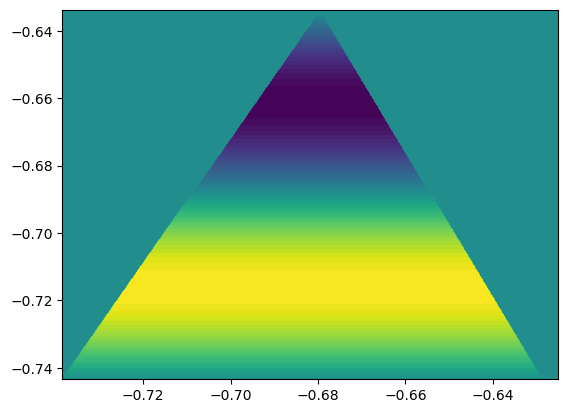

In [16]:
vi = clat_vertices[vid,:]
vj = clon_vertices[vid,:]

vip, vjp = ll_xy_projection(vi, vj, lat_centre, lon_centre)
print(vip, vjp)
inout = [pointInTriangle(vip,vjp,i,j) for i in lat_proj for j in lon_proj]
inout = np.array(inout).reshape(len(lat_proj),len(lon_proj))
z_masked_p = z*inout

plt.figure()
plt.contourf(lon_proj,lat_proj,z_masked_p,60)
x = np.append(vip,vip[0])
y = np.append(vjp,vjp[0])

# plt.plot(x,y,'-r')
plt.show()

#### Image moments function. 
Ref: https://en.wikipedia.org/wiki/Image_moment#Raw_moments

In [533]:
import imageio as misc

def raw_moment(data, i_order, j_order):
    nrows, ncols = data.shape
    y_indices, x_indicies = np.mgrid[:nrows, :ncols]
    return (data * x_indicies**i_order * y_indices**j_order).sum()

def moments_cov(data):
    data_sum = data.sum()
    m10 = raw_moment(data, 1, 0)
    m01 = raw_moment(data, 0, 1)
    x_centroid = m10 / data_sum
    y_centroid = m01 / data_sum
    u11 = (raw_moment(data, 1, 1) - x_centroid * m01) / data_sum
    u20 = (raw_moment(data, 2, 0) - x_centroid * m10) / data_sum
    u02 = (raw_moment(data, 0, 2) - y_centroid * m01) / data_sum
    cov = np.array([[u20, u11], [u11, u02]])
    return cov

def get_pca(z_masked, plot_diag = False):
    img = np.copy(z_masked)
    imin = img.min()
    # img -= imin
    y, x = np.nonzero(img)

    xm = np.mean(x)
    ym = np.mean(y)

    x = x - xm
    y = y - ym
    coords = np.vstack([x, y])

    supp_img = np.copy(img)
    supp_img[np.where(img < 0.0)] = 0.0
    supp_img[np.where(img > 0.0)] = 1.0
    # supp_img[np.where(img > 0.0)] = img[inout][np.where(img[inout] > 0.0)].mean()
    # supp_img -= supp_img.min()
    cov = moments_cov(supp_img)
    evals, evecs = np.linalg.eig(cov)

    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    if plot_diag == True:
        scale = 30.0
        plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
        plt.plot([x_v1*-scale*2, x_v1*scale*2],
                 [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
                 [y_v2*-scale, y_v2*scale], color='blue')
        plt.axis('equal')
        plt.show()
    return x_v1, x_v2, y_v1, y_v2


In [534]:
import scipy 

def rotate_topo(x_v1, x_v2, y_v1, y_v2, img, theta = None, plot_diag = False, verbose = False):
    if theta is None:
        theta = -np.arctan((y_v1)/(x_v1))
        
    if verbose:
        print("theta in degrees:", np.around(theta / np.pi * 180,2))
        
    if np.abs(theta) == np.pi:
        theta -= 0.01
        
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta),0],
                              [np.sin(theta), np.cos(theta),0],
                              [0,0,1]])

    # print(x_transformed)
    yarg, xarg = np.nonzero(img)

    xm = np.mean(xarg)
    ym = np.mean(yarg)

    x = xarg - xm
    y = yarg - ym
#     coords = np.vstack([x, y])

#     transformed_mat = rotation_mat * coords
#     # plot the transformed blob
#     x_transformed, y_transformed = transformed_mat.A
    
    def shear(angle,x,y):
        '''
        |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
        |0      1     |  |sin(𝜃)   1|  |0      1     |
        '''
        # shear 1
        tangent=np.tan(angle/2)
        new_x = (x-y*tangent)
        new_y = y

        #shear 2
        new_y = (new_x*np.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix

        #shear 3
        new_x = (new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix

        return new_y,new_x
    y_transformed, x_transformed = shear(theta, x, y)
    
    x_transformed = (x_transformed + xm).astype(int)
    y_transformed = (y_transformed + ym).astype(int)

    z_transformed = np.zeros_like(img)
    inout_rot = np.zeros_like(inout)

    z_transformed[y_transformed,x_transformed] = img[yarg,xarg]
    inout_rot[y_transformed,x_transformed] = inout[yarg,xarg]
    
#     m, n = img.shape
#     offset = ((m-1)/2, (n-1)/2)
#     to, fro = np.identity(3), np.identity(3)
#     offset = np.asanyarray(offset)
#     to[:2, 2] = offset
#     fro[:2, 2] = -offset

#     R = to @ rotation_mat @ fro
#     z_transformed = scipy.ndimage.affine_transform(img, R)
#     inout_rot = scipy.ndimage.affine_transform(inout, R)

    lon_mgrid_prep, lat_mgrid_prep = np.meshgrid(lon,lat)
    lat_rot = np.zeros_like(lat_mgrid_prep)
    lon_rot = np.zeros_like(lon_mgrid_prep)

    lat_rot[y_transformed,x_transformed] = lat_mgrid_prep[yarg,xarg]
    lon_rot[y_transformed,x_transformed] = lon_mgrid_prep[yarg,xarg]

#     lat_rot = scipy.ndimage.affine_transform(lat_mgrid_prep, rotation_mat)
#     lon_rot = scipy.ndimage.affine_transform(lon_mgrid_prep, rotation_mat)
    
    if plot_diag == True:
        plt.imshow(z_transformed, extent=[-img.shape[1]/2., img.shape[1]/2., -img.shape[0]/2., img.shape[0]/2. ], origin='lower')
        plt.axis('equal')
        plt.show()
    
    return z_transformed, inout_rot, lat_rot, lon_rot

    
# plt.plot(x, y, 'r.')

# plt.imshow(z_masked)
# print(x_transformed.shape, y_transformed.shape)
# plt.contourf(x_transformed, y_transformed,z_,60)

#### Plot the transformed topography with the principal axes.

-24.488095787517867


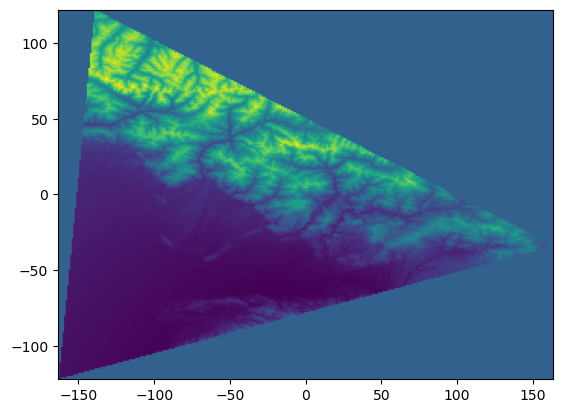

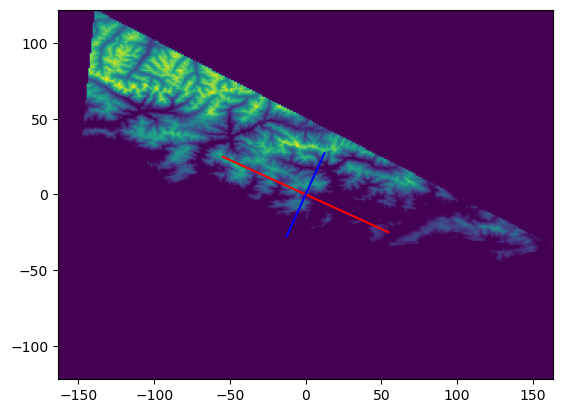

In [669]:
img = np.copy(z_masked)
y, x = np.nonzero(img)

xm = np.mean(x)
ym = np.mean(y)

x = x - xm
y = y - ym
coords = np.vstack([x, y])

# img -= img.min()
supp_img = np.copy(img)
supp_img[np.where(img < 0.0)] = 0.0
# supp_img[np.where(img > 0.0)] = 1.0
# supp_img[np.where(img < 0.0)] = img[inout][np.where(img[inout] < 0.0)].mean()
# supp_img[np.where(img > 0.0)] = img[inout][np.where(img[inout] > 0.0)].mean()
# supp_img -= supp_img.min()
cov = moments_cov(supp_img)
# img += img.min()
evals, evecs = np.linalg.eig(cov)

sort_indices = np.argsort(evals)[::-1]
x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
x_v2, y_v2 = evecs[:, sort_indices[1]]

theta = np.arctan((y_v1)/(x_v1))
print(theta / np.pi * 180)

scale = 30.0
plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
plt.show()
plt.imshow(supp_img, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
plt.show()

#### Play with different ways of setting up the RHS for the linear regression problem.

In [20]:
import scipy.ndimage as simg

plt.figure()
z_test = np.copy(z_transformed)

# for _ in range(100):
#     z_test = np.pad(z_test,((0,0),(1,1)))
#     z_test = (z_test[:,2:] - 2.0 * z_test[:,1:-1] + z_test[:,:-2])
#     z_test = (z_test[:,1:] + z_test[:,:-1]) / 2.0
    
# z_test = simg.gaussian_filter1d(z_test,4.0,1)
# print(z_test.shape)
# z_min = z_test.min()
# z_test[np.where(z_test < 0.0)] = 0.0
# z_test -= z_min
# z_test[np.where(z_test > 0.0)] = z_test[inout_rot][np.where(z_test[inout_rot] > 0.0)].mean()
plt.imshow(z_test, origin = 'lower')
plt.show()

NameError: name 'z_transformed' is not defined

<Figure size 640x480 with 0 Axes>

#### Vectorize the selected topography and the corresponding lat,lon

In [535]:
# lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
# lat_cell,lon_cell,z_cell = lat_mgrid[inout],lon_mgrid[inout],z[inout]

def get_IJ(lat_rot, lon_rot, inout_rot, z_test):
    lat_cell,lon_cell,z_cell = lat_rot[inout_rot],lon_rot[inout_rot],z_test[inout_rot]

    # now define appropriate indices for the points withing the triangle
    # by shifting the origin to the minimum lat and lon
    lat_res = lat[1] - lat[0]
    lon_res = lon[1] - lon[0]
    J = np.ceil((lat_cell - lat_cell.min())/lat_res).astype(int)
    I = np.ceil((lon_cell - lon_cell.min())/lon_res).astype(int)
    
    return I, J, lat_cell, lon_cell, z_cell

#### Niraj's Fourier routine

In [22]:
# def fitFourierSeries(data,Ni,Nj,I,J,nhar_i,nhar_j):
    # data, I, J must be in 1D
    # Ni, Nj: total number of points in i and j indices
    # nhar_i, nhar_j: number of harmonics in i and j index
    
    # number of harmonics for x,y
# m_i, n_j = range(nhar_i), range(nhar_j)

# # basis matrix
# basis_cos = []
# basis_sin = []
# for k in range(len(data)):
#     coeff_cos = [np.cos(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j]
#     coeff_sin = [np.sin(2*np.pi*(mm*I[k]/Ni + nn*J[k]/Nj)) for mm in m_i for nn in n_j if mm!=0 or nn!=0]
#     basis_cos.append(coeff_cos)
#     basis_sin.append(coeff_sin)

# coeff = np.hstack([basis_cos,basis_sin])
# print(coeff.shape)
# tot_coeff = coeff.shape[1]
# print('Total coefficients:',tot_coeff)

# # Solve: data_k = \sum basis_kl*a_l + \epsilon
# # obtain a_l using least square minimization of the error \epsilon
# # alternative

# h_tilda_l = np.zeros((tot_coeff,))
# E_tilda_lm = np.zeros((tot_coeff,tot_coeff))

# for l in range(tot_coeff):
#     h_tilda_l[l] = np.sum(data*coeff[:,l])
#     E_tilda_lm[l,:] = np.sum(coeff*np.expand_dims(coeff[:,l], axis=1), axis=0)

# # now invert E_tilda_lm to get the coefficients
# a_m = np.linalg.inv(E_tilda_lm).dot(h_tilda_l)

# # regular FFT considers normalization by total number of datapoints N=100
# # so multiply the Fourier coefficients by N here
# a_m = a_m*len(data)

# mid = (a_m.size+1)//2
# fourier_coeff = (a_m[1:mid] + 1j*a_m[mid:])/2    # half the amplitudes are the Fourier coefficients
# fourier_coeff = np.insert(fourier_coeff,0,a_m[0])
# fourier_coeff = fourier_coeff.reshape((nhar_i,nhar_j))

# # reconstruct the dataset
# data_recons = coeff.dot(a_m)/len(data)
    
#     return fourier_coeff, data_recons

#### Setup Fourier routine

In [536]:
def prepare_terms(lat_cell, lon_cell, I, J):
    
    Ni, Nj = np.unique(lat_cell).size, np.unique(lon_cell).size

    m_i = np.arange(0,nhar_i)
    if nhar_j == 2:
        m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    elif nhar_j % 2 == 0:
        m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    else:
        m_j = np.arange(-(nhar_j-1)/2,(nhar_j+1)/2)
        
    if debug_common:
        print("m_i; len(m_i); m_j; len(m_j)")
        print(m_i, len(m_i), '\n', m_j, len(m_j))

    term1 = m_i.reshape(1,-1) * I.reshape(-1,1) / Ni
    term2 = m_j.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    return term1, term2, Ni, Nj, m_i, m_j

def axial_f_coeffs(lat_cell, lon_cell, I, J, k_range = 1, l_range = 1, alpha = 0.0):
    
    term1, term2, Ni, Nj, m_i, m_j = prepare_terms(lat_cell, lon_cell, I, J)
    
    alpha = alpha / 180.0 * np.pi
    
    ktil = m_i * np.cos(alpha)
    ltil = m_i * np.sin(alpha)
    
    term1 = ktil.reshape(1,-1) * I.reshape(-1,1) / Ni + ltil.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    khat = m_j * np.cos(alpha + np.pi/2.0)
    lhat = m_j * np.sin(alpha + np.pi/2.0)
    
    term2 = khat.reshape(1,-1) * I.reshape(-1,1) / Ni + lhat.reshape(1,-1) * J.reshape(-1,1) / Nj
    
    bcos = 2.0 * np.cos(2.0 * np.pi * np.hstack([term1, term2[:,int(nhar_j/2):]]))
    bsin = 2.0 * np.sin(2.0 * np.pi * np.hstack([term1[:,1:], term2[:,int(nhar_j/2):]]))
    
    if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_axial)):
        print("term1: ")
        print(term1[999,...])
        print("term2: ")
        print(term2[999,...])
        
        print("bcos: ")
        print(bcos[999,...])

        print("bsin: ")
        print(bsin[999,...])

    Ncos = bcos[...]
    Nsin = bsin[...]
    
    return Ncos, Nsin

def full_f_coeffs(lat_cell, lon_cell, I, J):
    
    term1, term2, Ni, Nj, m_i, m_j = prepare_terms(lat_cell, lon_cell, I, J)
    
    
    term1 = np.expand_dims(term1,-1)
    term1 = np.repeat(term1,nhar_j,-1)
    term2 = np.expand_dims(term2,1)
    term2 = np.repeat(term2,nhar_i,1)
    
    term_sum = (term1[999:1001,...] + term2[999:1001,...])
    term_sum = term_sum.reshape(term_sum.shape[0], -1)

    tt_sum = term1 + term2
    tt_sum = tt_sum.reshape(tt_sum.shape[0],-1)

    bcos = 2.0 * np.cos(2.0 * np.pi * (tt_sum))
    bsin = 2.0 * np.sin(2.0 * np.pi * (tt_sum))

    if ((nhar_i == 2) and (nhar_j == 2)):
        Ncos = bcos[:,:]
        Nsin = bsin[:,1:]
        # Nsin = np.hstack((bsin[:,:2], bsin[:,3].reshape(-1,1)))#[:,1:]
    else:
        if (nhar_j % 2 == 0):
            Ncos = bcos[:,int(nhar_j/2-1):]
            Nsin = bsin[:,int(nhar_j/2):]
        else:
            Ncos = bcos[:,int(nhar_j/2-1):]
            Nsin = bsin[:,int(nhar_j/2):]

    if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_full)):
        print("term1: ")
        print(term1[999,...])
        print("term2: ")
        print(term2[999,...])
        print("term1; term2 shapes: ")
        print(term1.shape, term2.shape)

        print("term_sum: ")
        print(term_sum)
        print("term sum shape: ", term_sum.shape)

        print("bcos: ")
        print(bcos[999,...])

        print("bsin: ")
        print(bsin[999,...])
    
        print("Ncos: ")
        print(Ncos[999,...], Ncos.shape)
        
        print("Nsin: ")
        print(Nsin[999,...], Nsin.shape)
    
    return Ncos, Nsin

#### Stack Fourier terms and invert E_tilda_lm to get the coefficients

In [537]:
def get_recon(Ncos, Nsin, data, typ='full'):
    coeff = np.hstack([Ncos,Nsin])
    tot_coeff = coeff.shape[1]

    E_tilda_lm = np.zeros((tot_coeff,tot_coeff))
    # h_tilda_l = (data.reshape(-1,1) * coeff).sum(axis=0)
    h_tilda_l = np.dot(coeff.T, data.reshape(-1,1)).flatten()

    # for k in range(0,len(data)):
    #     E_tilda_lm += np.expand_dims(coeff[k],-1) * np.expand_dims(coeff[k],0)
    E_tilda_lm = np.dot(coeff.T, coeff)

    import scipy.linalg as la

    a_m = la.inv(E_tilda_lm).dot(h_tilda_l)

    # regular FFT considers normalization by total nu  mber of datapoints N=100
    # so multiply the Fourier coefficients by N here
    a_m = a_m#*len(data)
    
    fourier_coeff = np.zeros((nhar_i, nhar_j))
    nc = Ncos.shape[1]
    
    if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and ((debug_full) or (debug_axial)) and (debug_common)):
        print("coeff [999]: ")
        print(coeff[999,:])
        print("coeff shape: ")
        print(coeff.shape)
        print('Total coefficients:',tot_coeff)

        print("am shape = ", a_m.shape)
        print("am: ")
        print(a_m)

        print("nc (length of Ncos) = ", nc)
    
    zrs = np.zeros((int(nhar_j/2)-1))
    
    if typ == 'full':
        f00 = a_m[0]
        cos_terms = a_m[:nc]
        sin_terms = a_m[nc:]
        
        if ((nhar_i == 2) and (nhar_j == 2)):
            sin_terms = np.concatenate(([0.0],sin_terms))
        else:
            cos_terms = np.concatenate((zrs,cos_terms))
            sin_terms = np.concatenate((zrs,[0.0],sin_terms))
        
        fourier_coeff = (cos_terms + 1.0j * sin_terms) / 2.0
        fourier_coeff = fourier_coeff.reshape(nhar_i,nhar_j).swapaxes(1,0)

        if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_full)):
            print("cos terms, sin_terms: ")
            print(cos_terms, sin_terms)

            print("fourier_coeff: ")
            print(fourier_coeff)
        
    if typ == 'axial':
        f00 = a_m[0]
        cos_terms = a_m[:nc]
        sin_terms = a_m[nc:]
        sin_terms = np.concatenate(([0.0], sin_terms))
        
        if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_axial)):
            print("cos_terms")
            print(cos_terms)

            print("sin terms")
            print(sin_terms)
        if (nhar_j %2 == 0):
            k_terms = (cos_terms[:nhar_i] + 1.0j * sin_terms[:nhar_i]) / 2.0
            l_terms = (cos_terms[nhar_i:] + 1.0j * sin_terms[nhar_i:]) / 2.0
            
    
            if ((nhar_i < debug_nh) and (nhar_j < debug_nh) and (debug_axial)):
                print("k-terms : ")
                print(k_terms, k_terms.shape)
                print("l-terms : ")
                print(l_terms, l_terms.shape)
            
            # y_axs = (cos_terms[:int(nhar_j/2-1)] + 1.0j * sin_terms[:int(nhar_j/2-1)]) / 2.0
            # x_axs = (cos_terms[int(nhar_j/2-1):] + 1.0j * sin_terms[int(nhar_j/2-1):]) / 2.0
            # x_axs = x_axs.reshape(-1,1)
            l_blk = np.zeros(( int(nhar_j/2-1), int(nhar_i) ))
            u_blk = np.zeros(( int(nhar_j/2), int(nhar_i-1) ))
            
            u_blk = np.hstack((l_terms.reshape(-1,1), u_blk))
            
            fourier_coeff = np.vstack((l_blk, k_terms, u_blk))
            
        else:
            y_axs = (cos_terms[:int((nhar_j+1)/2+1)] + 1.0j * sin_terms[:int((nhar_j+1)/2+1)]) / 2.0
            x_axs = (cos_terms[int((nhar_j-1)/2):] + 1.0j * sin_terms[int((nhar_j-1)/2):]) / 2.0
            x_axs = x_axs.reshape(-1,1)
            l_blk = np.zeros(( int(nhar_i-1), int((nhar_j-1)/2-1) ))
            u_blk = np.zeros(( int(nhar_i-1), int((nhar_j-1)/2) ))
            
            # print(x_axs.shape, l_blk.shape, u_blk.shape)
        
            r1 = np.hstack(([0]*int(nhar_j/2),[f00],y_axs)).reshape(1,-1)
            r2 = np.hstack((u_blk,x_axs,l_blk))
            fourier_coeff = np.vstack((r1,r2))
            fourier_coeff = fourier_coeff.T
            
    # print(f00)
        
    # fourier_coeff /= fourier_coeff.max()
    
    # reconstruct the dataset
    data_recons = coeff.dot(a_m)#/len(data)
    print(a_m.shape)

    recons_z = data_recons
    
    return recons_z, fourier_coeff

#### Reshape the reconstructed topography to the trianglular form

In [555]:
def recon_2D(recons_z, z, inout_rot):
    recons_z_2D = np.zeros(np.shape(z))
    c = 0
    for i in range(len(lat)):
        for j in range(len(lon)):
    #         if (inout[i,j] == 1):
    #             recons_z_2D[i,j] = recons_z[c]
    #             c = c+1

            if (inout_rot[i,j] == 1):
                recons_z_2D[i,j] = recons_z[c]
                c = c+1
                
    return recons_z_2D

# print(c)

In [556]:
plot_diag = False
debug_nh = 7
debug_full = False
debug_axial = False
debug_common = False

nhar_i = 12
nhar_j = 12

x_v1, x_v2, y_v1, y_v2 = get_pca(z_masked, plot_diag = plot_diag)

z_transformed, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_masked, theta=0.0, plot_diag = plot_diag, verbose = False)

Ncells_in_triangle = np.sum(inout)
I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, inout_rot, z_masked)

Ncos, Nsin = full_f_coeffs(lat_cell, lon_cell, I, J)
recons_z, fourier_coeffs = get_recon(Ncos, Nsin, z_cell)

recons_z_2D = recon_2D(recons_z, z_masked, inout_rot)

fourier_coeffs_full = np.copy(fourier_coeffs)

print("\n==================== AXIAL ====================\n")

Ncos, Nsin = axial_f_coeffs(lat_cell, lon_cell, I, J, alpha=0.0)
recons_z, fourier_coeffs = get_recon(Ncos, Nsin, z_cell, typ='axial')

recons_z_2D_axial = recon_2D(recons_z, z_masked, inout_rot)

(277,)

==================== AXIAL ====================

(35,)


In [27]:

lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)

fs = (16,24)

# plt.figure(figsize=fs)
# plt.imshow(inout_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(lat_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.colorbar()

# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(lon_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(recons_z_2D, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(z_orig, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.colorbar()
# plt.show()
# plt.figure(figsize=fs)
# plt.imshow(recons_z_rot, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.colorbar()
# plt.show()
# plt.figure(figsize=fs)

# plt.figure(figsize=fs)
# plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.title('original')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=fs)
# plt.imshow(recons_z_2D, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.title('full')
# plt.colorbar()

# plt.figure(figsize=fs)
# plt.imshow(recons_z_2D_axial, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.title('axial')
# plt.colorbar()

# plt.figure(figsize=fs)
# plt.imshow(recons_z_2D - recons_z_2D_axial, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower')
# plt.title('axial')
# plt.colorbar()

# scale = 30.0
# plt.plot([x_v1*-scale*2, x_v1*scale*2],
#          [y_v1*-scale*2, y_v1*scale*2], color='red')
# plt.plot([x_v2*-scale, x_v2*scale],
#          [y_v2*-scale, y_v2*scale], color='blue')
# plt.show()

print(np.linalg.norm(recons_z_2D - z_masked))

51.429314280360614


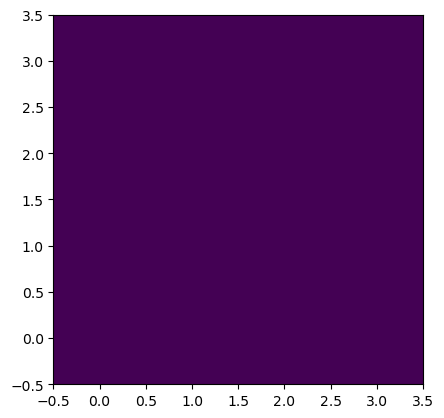

In [28]:
tarr = np.copy(fourier_coeffs_full)
plt.imshow(np.abs(tarr))
tarr[0:5,:] = 0.0
tarr[6:,1:] = 0.0
plt.imshow(np.abs(tarr), origin='lower')

In [551]:
fs = (12,16)
fig, axs = plt.subplots(3, 2, figsize=fs)
vmin = -1500
vmax = 1500

extent = [-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ]

im1 = axs[0,0].imshow(z_masked, vmin=vmin, vmax=vmax, extent=extent, origin='lower')
axs[0,0].set_title('original')
fig.colorbar(im1, ax=axs[0,0])

im6 = axs[0,1].imshow(np.abs(recons_z_2D - recons_z_2D_axial), extent=extent, origin='lower')
axs[0,1].set_title('abs. diff')
fig.colorbar(im6, ax=axs[0,1])

im2 = axs[1,0].imshow(recons_z_2D, vmin=vmin, vmax=vmax, extent=extent, origin='lower', aspect='equal')
axs[1,0].set_title('full')
fig.colorbar(im2, ax=axs[1,0])
# axs[1,0].set_aspect('equal')

im3 = axs[1,1].pcolormesh(np.abs(fourier_coeffs_full), edgecolors='k', cmap='Greys')
fig.colorbar(im3,ax=axs[1,1],fraction=0.05, pad=0.04)

m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    
ylocs = np.arange(.5,nhar_j+.5,1.0)

axs[1,1].set_yticks(ylocs, m_j)
axs[1,1].set_xticks(ylocs, np.arange(0,nhar_j))
axs[1,1].set_title("Power spectrum")
axs[1,1].set_xlabel(r'$k_n$', fontsize=12)
axs[1,1].set_ylabel(r'$l_m$', fontsize=12)
axs[1,1].set_aspect('equal')

im4 = axs[2,0].imshow(recons_z_2D_axial, vmin=vmin, vmax=vmax, extent=extent, origin='lower')
axs[2,0].set_title('axial')
fig.colorbar(im4, ax=axs[2,0])

im5 = axs[2,1].pcolormesh(np.abs(fourier_coeffs), edgecolors='k', cmap='Greys')
fig.colorbar(im5,ax=axs[2,1],fraction=0.05, pad=0.04)
    
ylocs = np.arange(.5,nhar_j+0.5,1.0)
axs[2,1].set_yticks(ylocs, m_j)
axs[2,1].set_xticks(ylocs, np.arange(0,nhar_j))
axs[2,1].set_title("Power spectrum")
axs[2,1].set_xlabel(r'$k_n$', fontsize=12)
axs[2,1].set_ylabel(r'$l_m$', fontsize=12)
axs[2,1].set_aspect('equal')

plt.show()
# print("Fourier ampls:")
# print((fourier_coeffs_full))
# print((fourier_coeffs))

# print("")
# print("abs(Fourier ampls):")
# print(np.abs(fourier_coeffs_full))
# print(np.abs(fourier_coeffs))

print("")
print((fourier_coeffs_full.max()), (fourier_coeffs.max()))
print(np.abs(fourier_coeffs_full.max()), np.abs(fourier_coeffs.max()))
print(np.abs(fourier_coeffs_full).max(), np.abs(fourier_coeffs).max())
# print(np.abs(fourier_coeffs_full).max() - np.abs(fourier_coeffs).max())
print(np.abs(fourier_coeffs_full).sum(), np.abs(fourier_coeffs).sum())
print(np.abs(fourier_coeffs_full).sum() / np.abs(fourier_coeffs).sum())
print(np.abs(fourier_coeffs_full).sum() - np.abs(fourier_coeffs).sum())
# print(np.abs(fourier_coeffs_full.max() - fourier_coeffs.max()))


(1939862.6488307985-872940.2830388917j) (207.21688597443426+255.0409299994094j)
2127226.3241321696 328.61027647945724
2850790.1274914737 598.7983284106175
76135439.26684593 2157.1542758279493
35294.38766618765
76133282.11257009


In [575]:
fs = (5,4)
fig, axs = plt.subplots(1, 1, figsize=fs)
vmin = -1500
vmax = 1500

extent = [-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ]

lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
im1 = axs.pcolormesh(lon_mgrid, lat_mgrid, z_masked, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
axs.set_xlabel(r'longitude [deg.]', fontsize=12)
axs.set_ylabel(r'latitude [deg.]', fontsize=12)
cbar = fig.colorbar(im1, ax=axs)
cbar.ax.set_ylabel('elevation [m]', rotation=270)

plt.show()

In [642]:
%matplotlib qt
fs = (17.5,4)
fig, axs = plt.subplots(1,3, figsize=fs, constrained_layout = False)
vmin = -1500
vmax = 1500

lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
im1 = axs[0].pcolormesh(lon_mgrid, lat_mgrid, z_masked, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
axs[0].set_xlabel(r'longitude [deg.]', fontsize=12)
axs[0].set_ylabel(r'latitude [deg.]', fontsize=12)
axs[0].set_title('GMTED2010 orography')

im2 = axs[1].pcolormesh(lon_mgrid, lat_mgrid, recons_z_2D, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
axs[1].set_xlabel(r'longitude [deg.]', fontsize=12)
axs[1].set_ylabel(r'latitude [deg.]', fontsize=12)
axs[1].set_title('Full spectrum reconstruction')

cbar = fig.colorbar(im2, ax=axs[:2], fraction=0.02, pad=0.01)
cbar.ax.set_ylabel('elevation [m]', rotation=270)

im3 = axs[2].pcolormesh(np.abs(fourier_coeffs_full), edgecolors='k', cmap='Greys')
fig.colorbar(im3,ax=axs[2],fraction=0.05, pad=0.04)

m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    
ylocs = np.arange(.5,nhar_j+.5,1.0)

axs[2].set_yticks(ylocs, m_j)
axs[2].set_xticks(ylocs, np.arange(0,nhar_j))
axs[2].set_title("Power spectrum")
axs[2].set_xlabel(r'$k_n$', fontsize=12)
axs[2].set_ylabel(r'$l_m$', fontsize=12)
axs[2].set_aspect('equal')

# plt.subplots_adjust(wspace=0.5)
plt.show()

In [645]:
%matplotlib qt
fs = (17.5,4)
fig, axs = plt.subplots(1,3, figsize=fs, constrained_layout = False)
vmin = -1500
vmax = 1500

lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
im1 = axs[0].pcolormesh(lon_mgrid, lat_mgrid, z_masked, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
axs[0].set_xlabel(r'longitude [deg.]', fontsize=12)
axs[0].set_ylabel(r'latitude [deg.]', fontsize=12)
axs[0].set_title('GMTED2010 orography')

im2 = axs[1].pcolormesh(lon_mgrid, lat_mgrid, recons_z_2D_axial, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
axs[1].set_xlabel(r'longitude [deg.]', fontsize=12)
axs[1].set_ylabel(r'latitude [deg.]', fontsize=12)
axs[1].set_title('Axial spectrum reconstruction')

cbar = fig.colorbar(im2, ax=axs[:2], fraction=0.02, pad=0.01)
cbar.ax.set_ylabel('elevation [m]', rotation=270)

im3 = axs[2].pcolormesh(np.abs(fourier_coeffs), edgecolors='k', cmap='Greys')
fig.colorbar(im3,ax=axs[2],fraction=0.05, pad=0.04)

m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    
ylocs = np.arange(.5,nhar_j+.5,1.0)

axs[2].set_yticks(ylocs, m_j)
axs[2].set_xticks(ylocs, np.arange(0,nhar_j))
axs[2].set_title("Power spectrum")
axs[2].set_xlabel(r'$k_n$', fontsize=12)
axs[2].set_ylabel(r'$l_m$', fontsize=12)
axs[2].set_aspect('equal')

# plt.subplots_adjust(wspace=0.5)
plt.show()

In [298]:
# ref : https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
from matplotlib.text import Annotation

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

In [300]:
# ref : https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D, 'arrow3D', _arrow3D)

In [552]:
from matplotlib import cm
from matplotlib.colors import LightSource, Normalize

from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

%matplotlib qt
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,6))

lon_rot, lat_rot = np.meshgrid(lon,lat)
zzt = np.ma.masked_array(recons_z_2D, mask=~inout, fill_value=np.nan)

x_scale=1
y_scale=1
z_scale=0.6

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj

ls = LightSource(45, 45)

# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
norm = Normalize(-1500, 1500, clip=True)
rgb = ls.shade(zzt, cmap=cm.viridis, norm=norm)
# rgb = ls.hillshade(zzt)

# Plot the surface.

surf = ax.plot_surface(lon_rot, lat_rot, zzt, vmax=1500, vmin=-1500, cmap=cm.viridis,
                       linewidth=0, alpha=0.75, antialiased=True, rstride=3, cstride=3,
                      shade=True, facecolors=rgb)

x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])

surf.set_clim(-1500,1500)
ax.plot(x,y,'-r', lw=2)
ax.plot(lon_centre, lat_centre, 'x', ms=10, alpha=1.0, mew=2, mec=(1,0,0,1))

# arrow_start = [lon_centre, lat_centre, 0.5]
# arrow_end   = [lon_centre, lat_centre + 0.2, 0.0]
arw_x = [lon_centre + 0.5 , lon_centre + 1.5]
arw_y = [lat_centre, lat_centre]
arw_z = [2500, 300]

# ax.plot(arw_x, arw_y, arw_z, 'r-')
# ax.quiver3D(lon_centre, lat_centre, 2300, 0.0, -0.5 , -1500, color='r', pivot='tip', length=1.0, arrow_length_ratio=0.001)
ax.arrow3D(lon_centre, lat_centre, 2300, 0.0, -0.5 , -1500, mutation_scale=20 , fc='lightyellow', lw=0.8 )

ax.set_yticks([41.5,42,42.5,43,43.5,44])
ax.set_xlabel("longitude [deg.]")
ax.set_ylabel("latitude [deg.]")
ax.set_label("latitude [deg.]")
ax.yaxis.labelpad=10
ax.xaxis.labelpad=10

annstr = 'background mean flow:\n'
annstr += r'$\vec{U} = (U,V)$'
ax.annotate3D(annstr, (lon_centre, lat_centre, 1500),
              xytext=(40, 0),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow",alpha=1.0))

annstr = r'$(x,y)$'
ax.annotate3D(annstr, (lon_centre-0.1, lat_centre, 0),
              xytext=(-60, -20),
              textcoords='offset points',
              bbox=dict(boxstyle="round", fc="lightyellow",alpha=1.0),
              arrowprops=dict(arrowstyle="-|>", ec='k', fc='lightyellow', lw=0.8 ,  mutation_scale=20))


ax.set_zlim(-1000, 2000)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel("elevation [m]", rotation=90)
ax.set_zticks([-1000,0,1000,2000])

ax.view_init(elev=15., azim=-160.)
# ax.view_init(elev=25., azim=125.)

# Customize the z axis.
# ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.01)

plt.tight_layout()
# plt.autoscale()
plt.show()


In [549]:
# ref : https://stackoverflow.com/questions/42611342/representing-voxels-with-matplotlib
def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C2"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data(p, size=s) )
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6, axis=0), **kwargs)

In [561]:

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

kk = np.arange(0,nhar_i)
ll = np.arange(-nhar_j/2+1,nhar_j/2+1)

N = 0.02 # s^{-1}
U = 10.0 # m s^{-1}
V = 10.0 # m s^{-1}

AE = 6371.0008 * 1E3 

lat_res = lat[1] - lat[0]
lon_res = lon[1] - lon[0]
    
kkg, llg = np.meshgrid(kk,ll)
kkgo, llgo = np.meshgrid(kk,ll)

kkg = kkg / (lon_res * AE)
llg = llg / (lat_res * AE)

omg_grid_sq = (- kkg * U - llg * V)**2
mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))

%matplotlib qt
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

x_scale=1
y_scale=1
z_scale=1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj=short_proj

kkgo = kkgo[mmg < 1e308] - 0.5
llgo = llgo[mmg < 1e308] - 0.5
mmg = mmg[mmg < 1e308]

positions = np.c_[kkgo,llgo,mmg * 1000.0]

pc = plotCubeAt(positions, edgecolor="k", alpha=1.0, lw=0.5)
ax.add_collection3d(pc)

ax.set_xlim([-0.5,nhar_i+.5])
ax.set_ylim([(-nhar_j/2+1)-0.5,(nhar_j/2)+.5])
ax.set_zlim([0.0,mmg.max()*1000.0+0.5])

ax.set_zticks(ax.get_zticks()[:-1], ax.get_zticks()[:-1]/1000.0)

ax.view_init(elev=15., azim=125.)

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$l$')
ax.set_zlabel(r'$m$')
# ax.set_aspect('equal')

plt.tight_layout()
plt.show()
# plt.savefig('test.pdf', bbox_inches='tight')

/tmp/ipykernel_9321/1618891521.py:22: RuntimeWarning: divide by zero encountered in true_divide
  mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))
/tmp/ipykernel_9321/1618891521.py:22: RuntimeWarning: invalid value encountered in true_divide
  mmg = np.sqrt((N**2 * (kkg**2 + llg**2) / omg_grid_sq) - (kkg**2 + llg**2))
/tmp/ipykernel_9321/1618891521.py:62: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [513]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data(p, size=s) )
    return Poly3DCollection(np.concatenate(g),  
                            facecolors=np.repeat(colors,6, axis=0), **kwargs)

N1 = 10
N2 = 10
N3 = 10
ma = np.random.choice([0,1], size=(N1,N2,N3), p=[0.99, 0.01])
x,y,z = np.indices((N1,N2,N3))+.5
# positions = np.c_[x[ma==1],y[ma==1],z[ma==1]]

# print(positions)
positions = [[-0.5,0.5,0.5]]
colors= np.random.rand(len(positions),3)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

pc = plotCubeAt(positions, colors=colors,edgecolor="k")
ax.add_collection3d(pc)

ax.set_xlim([-0.5,10.5])
ax.set_ylim([-0.5,10.5])
ax.set_zlim([-0.5,10.5])
#plotMatrix(ax, ma)
#ax.voxels(ma, edgecolor="k")

plt.show()

In [30]:
rng = range(2,19,2)
am_sum_full = np.zeros((len(rng)))
am_sum_axis = np.zeros((len(rng)))
am_max_full = np.zeros((len(rng)))
am_max_axis = np.zeros((len(rng)))

cnt = 0
for ij in rng:
    nhar_i = ij
    nhar_j = ij

    x_v1, x_v2, y_v1, y_v2 = get_pca(z_masked, plot_diag = plot_diag)

    z_transformed, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_masked, theta=0.0, plot_diag = plot_diag, verbose = False)

    Ncells_in_triangle = np.sum(inout)
    I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, inout_rot, z_masked)

    Ncos, Nsin = full_f_coeffs(lat_cell, lon_cell, I, J)
    recons_z, fourier_coeffs = get_recon(Ncos, Nsin, z_cell)
    
    fourier_coeffs_full = np.copy(fourier_coeffs)

    print("\n==================== AXIAL ====================\n")

    recons_z_2D = recon_2D(recons_z, z_masked, inout_rot)

    Ncos, Nsin = axial_f_coeffs(lat_cell, lon_cell, I, J, alpha=0.0)
    recons_z, fourier_coeffs = get_recon(Ncos, Nsin, z_cell, typ='axial')

    recons_z_2D_axial = recon_2D(recons_z, z_masked, inout_rot)
    
    am_sum_full[cnt] = np.abs(fourier_coeffs_full).sum()
    am_sum_axis[cnt] = np.abs(fourier_coeffs).sum()
    am_max_full[cnt] = np.abs(fourier_coeffs_full).max()
    am_max_axis[cnt] = np.abs(fourier_coeffs).max()
    
    cnt += 1


==================== AXIAL ====================


==================== AXIAL ====================


==================== AXIAL ====================


==================== AXIAL ====================


==================== AXIAL ====================


==================== AXIAL ====================


==================== AXIAL ====================


==================== AXIAL ====================


==================== AXIAL ====================



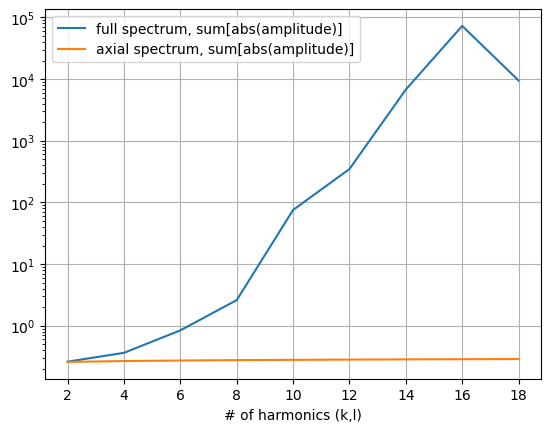

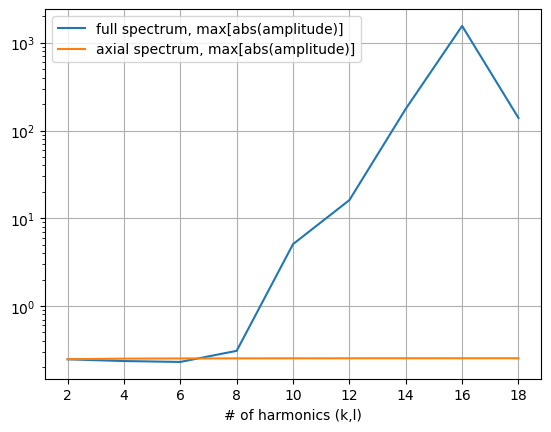

In [31]:
plt.figure()
plt.semilogy(am_sum_full, label='full spectrum, sum[abs(amplitude)]')
plt.semilogy(am_sum_axis, label='axial spectrum, sum[abs(amplitude)]')
plt.xticks(np.arange(0,len(rng)), rng)
plt.xlabel('# of harmonics (k,l)')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.semilogy(am_max_full, label='full spectrum, max[abs(amplitude)]')
plt.semilogy(am_max_axis, label='axial spectrum, max[abs(amplitude)]')
plt.xticks(np.arange(0,len(rng)), rng)
plt.xlabel('# of harmonics (k,l)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
ffmax = np.abs(fourier_coeffs_full).max()
famax = np.abs(fourier_coeffs).max()
ffmin = np.abs(fourier_coeffs_full).min()
famin = np.abs(fourier_coeffs).min()
ffsum = np.abs(fourier_coeffs_full).sum()
fasum = np.abs(fourier_coeffs).sum()

ff = fourier_coeffs_full
fa = fourier_coeffs

print(ffmax/famax)
# print(np.abs(fourier_coeffs_full).sum(), np.abs(fourier_coeffs).sum())

In [ ]:
124654822.40439679 / 34508.326270110236

In [ ]:
fourier_coeffs.shape
print(fourier_coeffs)

In [569]:
fs = (4,4)
plt.figure(figsize=fs)

lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)

# im = plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin, cmap='cividis')
im = plt.pcolormesh(lon_mgrid, lat_mgrid, z_masked, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
plt.colorbar(im,fraction=0.05, pad=0.04)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('GMTED 2010 Topography')
# plt.savefig('gmted.pdf', bbox_inches='tight', dpi=1200)
plt.show()

In [ ]:
fs = (4,4)
plt.figure(figsize=fs)
# im = plt.imshow(z_masked, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin, cmap='cividis')
im = plt.pcolormesh(lon_mgrid, lat_mgrid, recons_z_2D, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
plt.colorbar(im,fraction=0.05, pad=0.04)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Reconstructed Topography')
# plt.savefig('full_recons.pdf', bbox_inches='tight', dpi=1200)
plt.show()

In [ ]:
fs = (4,3.8)
plt.figure(figsize=fs)

im = plt.pcolormesh(np.abs(fourier_coeffs), edgecolors='k', cmap='Greys')
plt.colorbar(im,fraction=0.05, pad=0.04)
if nhar_j % 2 == 0:
    m_j = np.arange(-nhar_j/2,nhar_j/2)
else:
    m_j = np.arange(-(nhar_j-1)/2,(nhar_j)/2)
    
ylocs = np.arange(.5,12.5,1.0)
# ylocs = np.arange(0,12)
print(ylocs)
plt.yticks(ylocs, m_j)
plt.xticks(ylocs, np.arange(0,12))
plt.title("Power spectrum")
plt.xlabel(r'$k_n$', fontsize=12)
plt.ylabel(r'$l_m$', fontsize=12)
# plt.grid()
# plt.savefig('axial_coeffs_rot.pdf', bbox_inches='tight')
plt.show()

In [665]:
%matplotlib inline

x_v1, x_v2, y_v1, y_v2 = get_pca(z_masked)

xs = np.arange(0,91,1)
theta_range = xs #/ 180.0 * np.pi
# theta_range = [1.0 / 180.0 * np.pi]
errs = []
Erot = []
Etot = []
Enai = []
Eful = []

z_transformed, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_masked, 0.0, verbose=True)
I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, inout_rot, z_transformed)

for theta in theta_range:
    print("theta in degrees = %.3f" %theta, end='\r')
    Ncos, Nsin = axial_f_coeffs(lat_cell, lon_cell, I, J, alpha=-theta)
    recons_z,_ = get_recon(Ncos, Nsin, z_cell, typ='axial')
    recons_z_2D = recon_2D(recons_z, z_transformed, inout_rot)

    Enai.append(np.linalg.norm(recons_z_2D - z_transformed))

theta in degrees: 0.0
(35,) in degrees = 0.000
(35,) in degrees = 1.000
(35,) in degrees = 2.000
(35,) in degrees = 3.000
(35,) in degrees = 4.000
(35,) in degrees = 5.000
(35,) in degrees = 6.000
(35,) in degrees = 7.000
(35,) in degrees = 8.000
(35,) in degrees = 9.000
(35,) in degrees = 10.000
(35,) in degrees = 11.000
(35,) in degrees = 12.000
(35,) in degrees = 13.000
(35,) in degrees = 14.000
(35,) in degrees = 15.000
(35,) in degrees = 16.000
(35,) in degrees = 17.000
(35,) in degrees = 18.000
(35,) in degrees = 19.000
(35,) in degrees = 20.000
(35,) in degrees = 21.000
(35,) in degrees = 22.000
(35,) in degrees = 23.000
(35,) in degrees = 24.000
(35,) in degrees = 25.000
(35,) in degrees = 26.000
(35,) in degrees = 27.000
(35,) in degrees = 28.000
(35,) in degrees = 29.000
(35,) in degrees = 30.000
(35,) in degrees = 31.000
(35,) in degrees = 32.000
(35,) in degrees = 33.000
(35,) in degrees = 34.000
(35,) in degrees = 35.000
(35,) in degrees = 36.000
(35,) in degrees = 37.000


In [666]:
Erot = np.array(Erot)
Etot = np.array(Etot)
Enai = np.array(Enai)
Eful = np.array(Eful)

In [683]:
errs = np.array(errs)

xs = np.arange(0,91,1)
# plt.figure()

err = Enai / Ncells_in_triangle
err_min = err.min()
err -= err.min()

plt.figure(figsize=(5,3.0))
plt.plot(xs, err, label="error", c='C0')

# print(np.argmin(Enai))

plt.axvline(np.argmin(Enai), c='C3', ls='--', lw=2.0, label=r'min(error) = $11^\circ$')
# plt.axvline(6.3, c='k', ls='--', lw=0.6)
plt.axvline(21.0, c='C2', ls='dashdot', lw=2.0, label=r'PCA optimal angle $\approx 24^\circ$')
xlbl = np.arange(0,91,10)
# plt.xlabel(xlbl,xlbl)
plt.xticks(xlbl)
# plt.axvline(53.1, c='k', ls='--', lw=0.6)
# plt.axvline(45, c='k')
# plt.axvline(46.7+90, c='k')
# plt.axvline(46.7+180, c='k')
# plt.title(r'$E_{\rm{rot}}$')
plt.legend(loc='lower right')
plt.xlabel("rotation [deg. CW]")
plt.ylabel("Err/N - min(Err/N)")
plt.xlim([0.0,90.0])
plt.grid()
plt.tight_layout()
plt.savefig('img/err_plot.pdf',bbox_inches='tight')
plt.show()

In [680]:
z_transformed, inout_rot, lat_rot, lon_rot = rotate_topo(x_v1, x_v2, y_v1, y_v2, z_masked, 0.0, verbose=True)
I, J, lat_cell, lon_cell, z_cell = get_IJ(lat_rot, lon_rot, inout_rot, z_transformed)

theta = 11.0

print("theta in degrees = %.3f" %theta, end='\r')
Ncos, Nsin = axial_f_coeffs(lat_cell, lon_cell, I, J, alpha=-theta)
recons_z, f_coeffs = get_recon(Ncos, Nsin, z_cell, typ='axial')
recons_z_2D = recon_2D(recons_z, z_transformed, inout_rot)

%matplotlib qt
fs = (17.5,4)
fig, axs = plt.subplots(1,3, figsize=fs, constrained_layout = False)
vmin = -1500
vmax = 1500

lon_mgrid, lat_mgrid = np.meshgrid(lon,lat)
im1 = axs[0].pcolormesh(lon_mgrid, lat_mgrid, z_masked, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
axs[0].set_xlabel(r'longitude [deg.]', fontsize=12)
axs[0].set_ylabel(r'latitude [deg.]', fontsize=12)
axs[0].set_title('GMTED2010 orography')

im2 = axs[1].pcolormesh(lon_mgrid, lat_mgrid, recons_z_2D, vmax=vmax, vmin=vmin, cmap='cividis', rasterized=True)
axs[1].set_xlabel(r'longitude [deg.]', fontsize=12)
axs[1].set_ylabel(r'latitude [deg.]', fontsize=12)
axs[1].set_title('Rotated axial spectrum reconstruction')

cbar = fig.colorbar(im2, ax=axs[:2], fraction=0.02, pad=0.01)
cbar.ax.set_ylabel('elevation [m]', rotation=270)

im3 = axs[2].pcolormesh(np.abs(f_coeffs), edgecolors='k', cmap='Greys')
fig.colorbar(im3,ax=axs[2],fraction=0.05, pad=0.04)

m_j = np.arange(-nhar_j/2+1,nhar_j/2+1)
    
ylocs = np.arange(.5,nhar_j+.5,1.0)

axs[2].set_yticks(ylocs, m_j)
axs[2].set_xticks(ylocs, np.arange(0,nhar_j))
axs[2].set_title("Power spectrum")
axs[2].set_xlabel(r'$k_n$', fontsize=12)
axs[2].set_ylabel(r'$l_m$', fontsize=12)
axs[2].set_aspect('equal')

# plt.subplots_adjust(wspace=0.5)
plt.show()

theta in degrees: 0.0
(35,) in degrees = 11.000


In [644]:
from matplotlib.patches import Rectangle

base = np.zeros((11,11))

origin = Rectangle((5,5),1,1,linewidth=1,facecolor='C0',alpha=0.5)
vax0 = Rectangle((5,0),1,5,linewidth=1,facecolor='w',alpha=0.25)
vax1 = Rectangle((5,6),1,5,linewidth=1,facecolor='C1',alpha=0.25)
hax0 = Rectangle((0,5),5,1,linewidth=1,facecolor='w',alpha=0.25)
hax1 = Rectangle((6,5),5,1,linewidth=1,facecolor='C2',alpha=0.25)

llq = Rectangle((0,0),5,5,linewidth=1,facecolor='w',alpha=0.25)
ulq = Rectangle((0,6),5,5,linewidth=1,facecolor='w',alpha=0.25)
lrq = Rectangle((6,0),5,5,linewidth=1,facecolor='w',alpha=0.25)
urq = Rectangle((6,6),5,5,linewidth=1,facecolor='w',alpha=0.25)

plt.figure(figsize=(4,4))
# plt.axhline(5.5,c='k',lw=2.0, alpha=0.75)
# plt.axvline(5.5,c='k',lw=2.0, alpha=0.75)
plt.pcolormesh(base, edgecolors='k', cmap='Greys',alpha=0.5)
ax = plt.gca()
ax.add_patch(origin)
ax.add_patch(vax0)
ax.add_patch(vax1)
ax.add_patch(hax0)
ax.add_patch(hax1)

ax.add_patch(llq)
ax.add_patch(ulq)
ax.add_patch(lrq)
ax.add_patch(urq)

# plt.plot((5.0,5.0),(5.0,11.0),'r',lw=2)
# plt.plot((5.0,6.0),(5.0,5.0),'r',lw=2)
# plt.plot((6.0,6.0),(0.0,5.0),'r',lw=2)

midpts = np.arange(0.5,11.5)
lbls = np.arange(-5,6)
plt.xticks(midpts,lbls)
plt.yticks(midpts,lbls)
plt.xlabel(r'$k_n$', fontsize=14)
plt.ylabel(r'$l_m$', fontsize=14)
plt.savefig('re_im_axial.pdf',bbox_inches='tight')
plt.show()


In [ ]:
#---- plot the topography and the spectrum
fig = plt.figure(figsize=(12,10))
# plot the topography within the cell
ax1 = fig.add_subplot(221)
# always use pcolormesh for plotting data with fine structures
sp1 = ax1.imshow(z_transformed, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# draw the cell
# x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
# y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
# ax1.plot(x,y,'-r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('SGS Topography')
fig.colorbar(sp1,ax=ax1)

# plot the reconstructed data
ax3 = fig.add_subplot(223)
sp3 = ax3.imshow(recons_z_2D, extent=[-z_masked.shape[1]/2., z_masked.shape[1]/2., -z_masked.shape[0]/2., z_masked.shape[0]/2. ], origin='lower', vmax=vmax, vmin=vmin)
# plt.plot(x,y,'-r')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Reconstructed SGS Topography')
fig.colorbar(sp3)
plt.show()
fig.savefig('SGS_spectrum_recons_andes.jpeg',dpi=300)

In [ ]:
#---- plot the topography and the spectrum
fig = plt.figure(figsize=(12,10))
vmin=-1500; vmax=1500
# plot the topography within the cell
ax1 = fig.add_subplot(221)
# always use pcolormesh for plotting data with fine structures
sp1 = ax1.pcolormesh(lon_mgrid,lat_mgrid,z_masked,
                     vmin=vmin,vmax=vmax,cmap=mpl.cm.RdBu,shading='auto')
# draw the cell
x = np.append(clon_vertices[vid,:],clon_vertices[vid,0])
y = np.append(clat_vertices[vid,:],clat_vertices[vid,0])
ax1.plot(x,y,'-r')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('SGS Topography')
fig.colorbar(sp1,ax=ax1)

# plot the spectrum -- Approach 1
# ax2 = fig.add_subplot(222)
# sp2 = plt.contourf(np.abs(spec),60)
# sp2 = plt.contourf(fourier_coeff1.real,60)
# ax2.set_xlabel(r'$k_x$',fontsize=14)
# ax2.set_ylabel(r'$k_y$',fontsize=14)
# ax2.set_title('SGS Spectrum (Approach 1)')
# cmap = mpl.cm.viridis
# norm = mpl.colors.Normalize(vmin=-10,vmax=10)
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap))
# plt.colorbar()

# plot the spectrum -- Approach 2
ax2 = fig.add_subplot(222)
sp2 = ax2.imshow(np.abs(fourier_coeffs))
fig.colorbar(sp2,ax=ax2)
ax2.set_xlabel(r'$k_x$',fontsize=14)
ax2.set_ylabel(r'$k_y$',fontsize=14)
ax2.set_title('SGS power spectrum')

# plot the reconstructed data
ax3 = fig.add_subplot(223)
sp3 = ax3.pcolormesh(lon_mgrid,lat_mgrid,recons_z_2D,
                     cmap=mpl.cm.RdBu,vmin=vmin,vmax=vmax,shading='auto')
plt.plot(x,y,'-r')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('Reconstructed SGS Topography')
fig.colorbar(sp3)
plt.show()
fig.savefig('SGS_spectrum_recons_andes.jpeg',dpi=300)

In [ ]:
ZZ = np.load('z.npy')

In [ ]:
print(ZZ.shape)
print(recons_z_2D.shape)
plt.figure()
plt.imshow(ZZ)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(recons_z_2D)
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(ZZ-recons_z_2D)
plt.colorbar()
plt.show()

print(la.norm(ZZ-z_masked)) #/ sum(z_masked))
print(la.norm(recons_z_2D-z_masked))# / sum(z_masked))